In [2]:
#coding=utf-8
import sys
import numpy as np
from src.common import *
from scipy.io import loadmat
from sklearn import metrics
from sklearn.decomposition import PCA
from sklearn.externals import joblib
from src.joint_bayesian import *
import cv2
import os.path
from PIL import Image
from align import AlignDlib
from numpy import expand_dims
from matplotlib import pyplot
from keras.models import load_model
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import f1_score, accuracy_score

In [4]:
# load the model
Facenet_model = load_model('models/facenet_keras.h5')
# summarize input and output shape
print(Facenet_model.inputs)
print(Facenet_model.outputs)

[<tf.Tensor 'input_1_1:0' shape=(?, 160, 160, 3) dtype=float32>]
[<tf.Tensor 'Bottleneck_BatchNorm_1/cond/Merge:0' shape=(?, 128) dtype=float32>]


In [5]:
def load_image(path):
    img = cv2.imread(path, 1)
    # OpenCV loads images with color channels
    # in BGR order. So we need to reverse them
    return img[...,::-1]

# Initialize the OpenFace face alignment utility
alignment = AlignDlib('models/shape_predictor_68_face_landmarks.dat')

def align_image(img):
    return alignment.align(160, img, alignment.getLargestFaceBoundingBox(img), 
                           landmarkIndices=AlignDlib.OUTER_EYES_AND_NOSE)


class IdentityMetadata():
    def __init__(self, base, name, file):
        # dataset base directory
        self.base = base
        # identity name
        self.name = name
        # image file name
        self.file = file

    def __repr__(self):
        return self.image_path()

    def image_path(self):
        return os.path.join(self.base, self.name, self.file) 
    
def load_metadata(path):
    metadata = []
    for i in sorted(os.listdir(path)):
        for f in sorted(os.listdir(os.path.join(path, i))):
            # Check file extension. Allow only jpg/jpeg' files.
            ext = os.path.splitext(f)[1]
            if ext == '.jpg' or ext == '.jpeg' or ext == '.png':
                metadata.append(IdentityMetadata(path, i, f))
    return np.array(metadata)

metadata = load_metadata('images')

In [6]:
embedded = []
metadata_curated = []

for i, m in enumerate(metadata):
    img = load_image(m.image_path())
    img = align_image(img)
    if img is None:
        pass
    else:
        # scale pixel values
        face_pixels = img.astype('float32')
        # standardize pixel values across channels (global)
        mean, std = face_pixels.mean(), face_pixels.std()
        face_pixels = (face_pixels - mean) / std
        metadata_curated.append(IdentityMetadata(m.base, m.name, m.file))
        # obtain embedding vector for image
        embedded.append(Facenet_model.predict(np.expand_dims(face_pixels, axis=0))[0])
metadata_curated = np.array(metadata_curated)
embedded = np.array(embedded)

In [8]:
data_to_pkl(embedded, "FaceNet-50_MOT360_fetures.pkl")

Saving data to file(FaceNet-50_MOT360_fetures.pkl). 


True

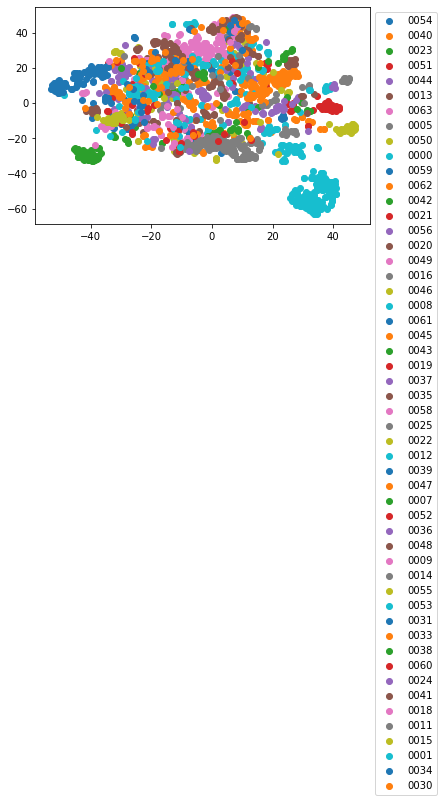

In [9]:
from sklearn.manifold import TSNE

targets = np.array([m.name for m in metadata_curated])
X_embedded = TSNE(n_components=2).fit_transform(embedded)

for i, t in enumerate(set(targets)):
    idx = targets == t
    pyplot.scatter(X_embedded[idx, 0], X_embedded[idx, 1], label=t)   

pyplot.legend(bbox_to_anchor=(1, 1));

In [13]:
from sklearn.preprocessing import LabelEncoder
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import LinearSVC

targets = np.array([m.name for m in metadata_curated])

encoder = LabelEncoder()
encoder.fit(targets)

# Numerical encoding of identities
y = encoder.transform(targets)

with open("data/train_idx_identification.pkl", "rb") as f:
    train_idx = pickle.load(f)
    
with open("data/test_idx_identification.pkl", "rb") as f:
    test_idx = pickle.load(f)

y_train = y[train_idx]
y_test = y[test_idx]

X_train = embedded[train_idx]
X_test = embedded[test_idx]

knn = KNeighborsClassifier(n_neighbors=1, metric='euclidean')
svc = LinearSVC()

knn.fit(X_train, y_train)
svc.fit(X_train, y_train)

acc_knn = accuracy_score(y_test, knn.predict(X_test))
acc_svc = accuracy_score(y_test, svc.predict(X_test))

print(f'KNN accuracy = {acc_knn}, SVM accuracy = {acc_svc}')

KNN accuracy = 0.8453038674033149, SVM accuracy = 0.850828729281768


In [14]:
targets = np.array([m.name for m in metadata_curated])

encoder = LabelEncoder()
encoder.fit(targets)

# Numerical encoding of identities
y = encoder.transform(targets)

with open("data/train_idx_verification.pkl", "rb") as f:
    train_idx = pickle.load(f)
    
with open("data/test_idx_verification.pkl", "rb") as f:
    test_idx = pickle.load(f)
    
y_train = y[train_idx]
y_test = y[test_idx]

X_train = embedded[train_idx]
X_test = embedded[test_idx]

In [16]:
with open("data/IntraPersonPair.pkl", "rb") as f:
    IntraPersonPair = pickle.load(f)
    
with open("data/ExtraPersonPair.pkl", "rb") as f:
    ExtraPersonPair = pickle.load(f)

print(len(IntraPersonPair))
print(len(ExtraPersonPair))
IntraPersonPair = IntraPersonPair[:6000]
ExtraPersonPair = ExtraPersonPair[:6000]

6000
6000


In [17]:
def excute_train(data, label):

    # pca training.
    pca = PCA_Train(data, 128)
    data_pca = pca.transform(data)

    JointBayesian_Train(data_pca, label)

In [18]:
excute_train(X_train, y_train)

2020-08-15, 17:42:22  number of components: 128
2020-08-15, 17:42:22  PCA training (n_components=128)...
2020-08-15, 17:42:22  PCA done.
(1269, 128)
prepare done, maxNumberInOneClass= 163


C:\Users\Abhilash\AppData\Roaming\Python\Python36\site-packages\sklearn\externals\joblib\numpy_pickle.py:93: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  pickler.file_handle.write(chunk.tostring('C'))
C:\Users\Abhilash\AppData\Roaming\Python\Python36\site-packages\sklearn\externals\joblib\numpy_pickle.py:93: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  pickler.file_handle.write(chunk.tostring('C'))
C:\Users\Abhilash\AppData\Roaming\Python\Python36\site-packages\sklearn\externals\joblib\numpy_pickle.py:93: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  pickler.file_handle.write(chunk.tostring('C'))
C:\Users\Abhilash\AppData\Roaming\Python\Python36\site-packages\sklearn\externals\joblib\numpy_pickle.py:93: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  pickler.file_handle.write(chunk.tostring('C'))
C:\Users\Abhilash\AppData\Roaming\Python\Python36\site-packages\sklearn\externals\joblib\num

2020-08-15, 17:42:23  Iterations-0: 0.0011530274609759044
Saving data to file(./G.pkl). 
Saving data to file(./A.pkl). 
2020-08-15, 17:42:23  Iterations-1: 0.0017010667179723727
2020-08-15, 17:42:24  Iterations-2: 0.0016390695678962684
2020-08-15, 17:42:25  Iterations-3: 0.0016587842471280857
2020-08-15, 17:42:25  Iterations-4: 0.0016000502577198153
2020-08-15, 17:42:26  Iterations-5: 0.0014537206983318025
2020-08-15, 17:42:27  Iterations-6: 0.0011317394113197464
Saving data to file(./G.pkl). 
Saving data to file(./A.pkl). 
2020-08-15, 17:42:27  Iterations-7: 0.000820006780224679
Saving data to file(./G.pkl). 
Saving data to file(./A.pkl). 
2020-08-15, 17:42:28  Iterations-8: 0.0008058383889358245
Saving data to file(./G.pkl). 
Saving data to file(./A.pkl). 
2020-08-15, 17:42:29  Iterations-9: 0.0008297953795872205
2020-08-15, 17:42:29  Iterations-10: 0.000681564034443936
Saving data to file(./G.pkl). 
Saving data to file(./A.pkl). 
2020-08-15, 17:42:30  Iterations-11: 0.00050582839920

2020-08-15, 17:43:25  Iterations-95: 1.3021997444327026e-05
2020-08-15, 17:43:26  Iterations-96: 1.3544935839532235e-05
2020-08-15, 17:43:27  Iterations-97: 1.411583737707875e-05
2020-08-15, 17:43:27  Iterations-98: 1.4740140523044435e-05
2020-08-15, 17:43:28  Iterations-99: 1.5424105748450795e-05
2020-08-15, 17:43:29  Iterations-100: 1.6174967041991174e-05
2020-08-15, 17:43:29  Iterations-101: 1.7001116995646083e-05
2020-08-15, 17:43:30  Iterations-102: 1.7912334318462078e-05
2020-08-15, 17:43:31  Iterations-103: 1.8920065107539523e-05
2020-08-15, 17:43:31  Iterations-104: 2.0037772854090714e-05
2020-08-15, 17:43:32  Iterations-105: 2.1281377035886133e-05
2020-08-15, 17:43:32  Iterations-106: 2.266980661720625e-05
2020-08-15, 17:43:33  Iterations-107: 2.4225704116477034e-05
2020-08-15, 17:43:34  Iterations-108: 2.5976328531873415e-05
2020-08-15, 17:43:34  Iterations-109: 2.795472362497635e-05
2020-08-15, 17:43:35  Iterations-110: 3.0201243828090762e-05
2020-08-15, 17:43:35  Iterations

In [19]:
with open("A.pkl", "rb") as f:
    A = pickle.load(f)
with open("G.pkl", "rb") as f:
    G = pickle.load(f)
clt_pca = joblib.load("pca_model.m")
data = clt_pca.transform(X_test)
data_to_pkl(data, "pca_lfw.pkl")

Saving data to file(pca_lfw.pkl). 


True

In [20]:
dist_Intra = get_ratios(A, G, IntraPersonPair, data)
dist_Extra = get_ratios(A, G, ExtraPersonPair, data)

dist_all = dist_Intra + dist_Extra
dist_all = np.asarray(dist_all)
label    = np.append(np.repeat(1, len(dist_Intra)), np.repeat(0, len(dist_Extra)))

data_to_pkl({"distance": dist_all, "label": label}, "result.pkl")

Saving data to file(result.pkl). 


True

In [21]:
excute_performance("result.pkl", -16.9, -16.6, 0.01)

[1 1 1 ... 0 0 0]
test size:  (12000,)
negative size:  (6000,)
postive size:  (6000,)
threshold:  -16.9
             precision    recall  f1-score   support

      False       0.83      0.93      0.88      6000
       True       0.92      0.81      0.86      6000

avg / total       0.87      0.87      0.87     12000

threshold:  -16.889999999999997
             precision    recall  f1-score   support

      False       0.83      0.93      0.88      6000
       True       0.92      0.81      0.86      6000

avg / total       0.87      0.87      0.87     12000

threshold:  -16.879999999999995
             precision    recall  f1-score   support

      False       0.83      0.93      0.88      6000
       True       0.92      0.81      0.86      6000

avg / total       0.87      0.87      0.87     12000

threshold:  -16.869999999999994
             precision    recall  f1-score   support

      False       0.83      0.93      0.88      6000
       True       0.92      0.81      0.86      